# KNN model for predicting impact position using datasets P1 based on **energy per band** features - Sound

### Model Description

This notebook implements a K-Nearest Neighbors (KNN) model to predict the position of an impact (C, S, V) based on sound features extracted from audio files. The workflow involves reading `.wav` files, extracting the **energy per band**, and training the model using these features. The model's performance is evaluated using accuracy metrics and visualized through scatter plots and a confusion matrix.

### Import libraries

In [2]:
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.io import wavfile
from scipy.fft import fft
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
import sys

c:\Users\Master\anaconda3\envs\venv1\Lib\site-packages\numpy\_core\_add_newdocs_scalars.py:27: RuntimeWarning: coroutine 'InteractiveShell.run_cell_async' was never awaited
  yield (alias_type, alias, doc)


### Import Tool Functions

In [3]:
# Reach the project root
notebook_path = os.path.abspath('')
project_root = os.path.abspath(os.path.join(notebook_path, '../../../'))
functions_path = os.path.join(project_root, 'Functions')

# Add Functions folder
if functions_path not in sys.path:
    sys.path.append(functions_path)

from readWavFolder import readWavFolder
from spectrumFromSignal import spectrumFromSignal
from energy_per_frequency_band_from_spectrum import energy_per_frequency_band_from_spectrum
p1_s_samples = "../../../Data/Sound/P1"

### Feature extraction example

213


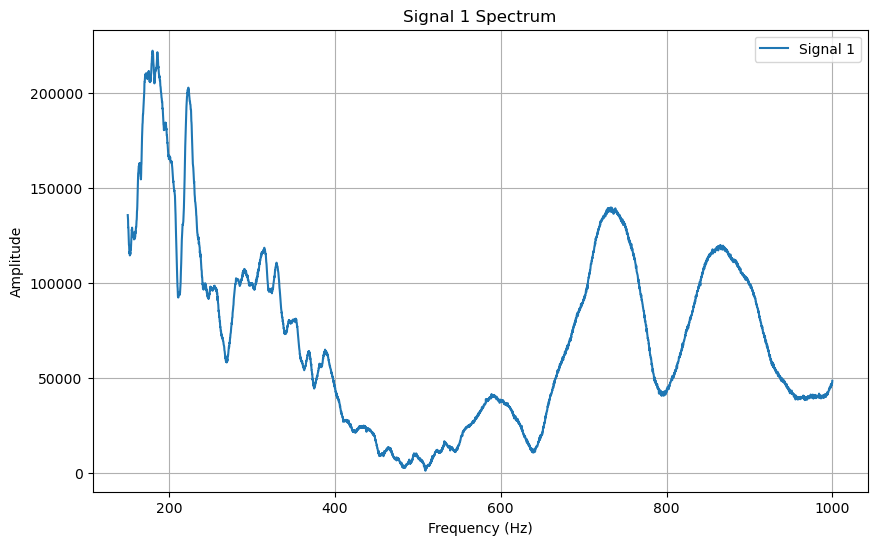

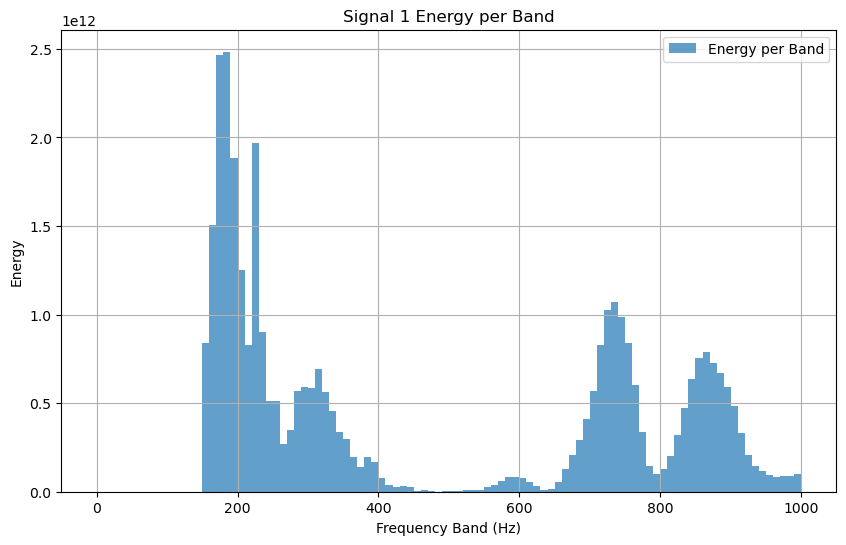

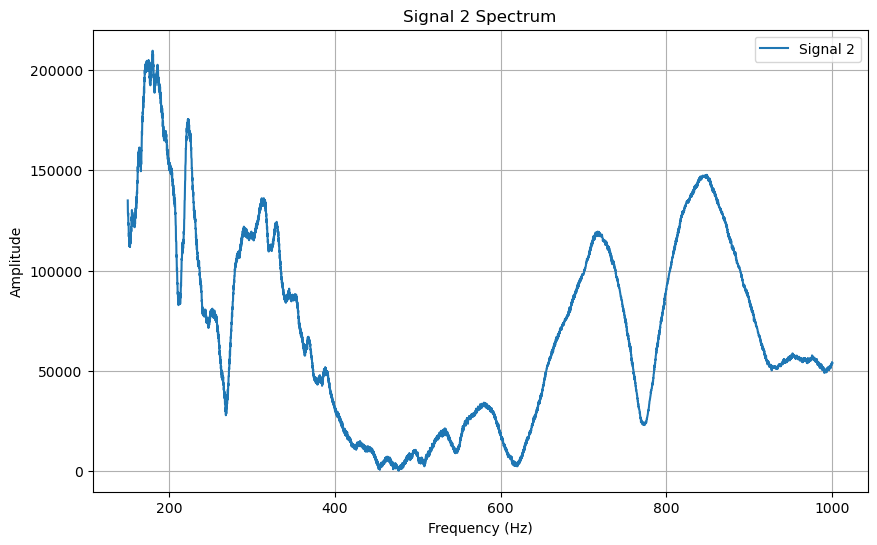

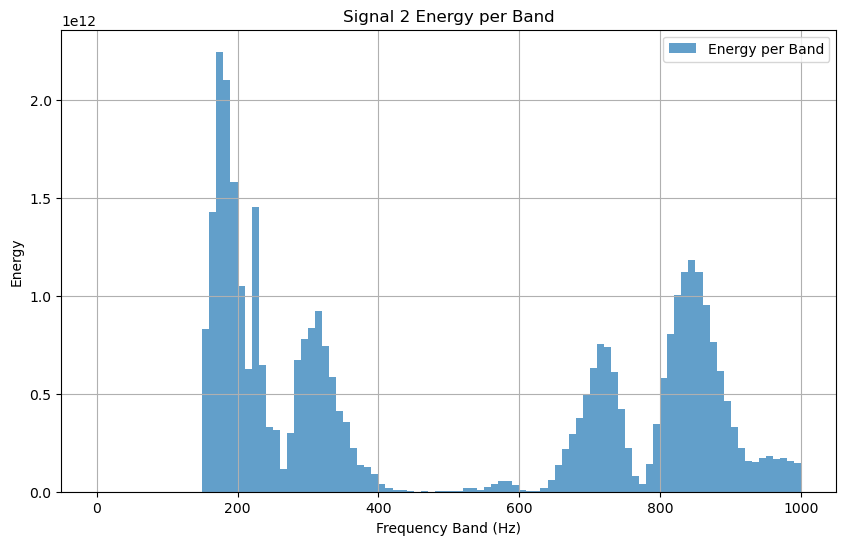

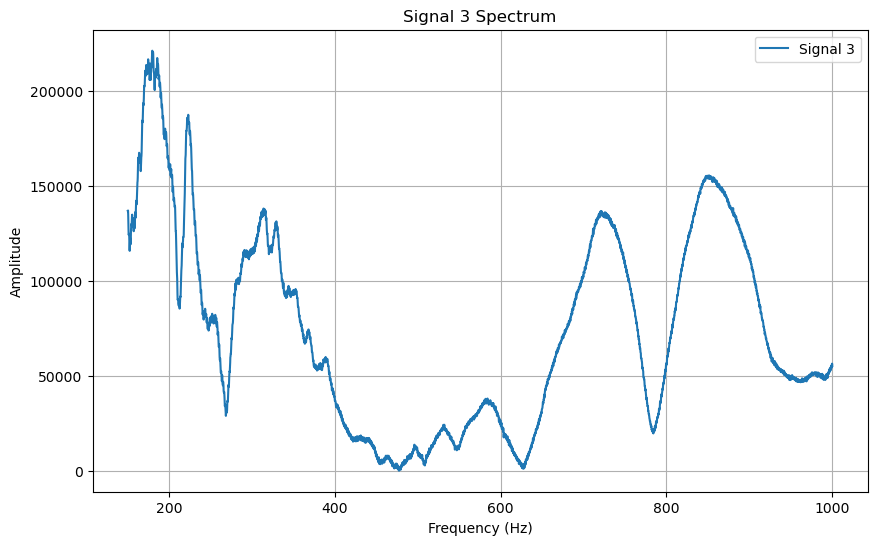

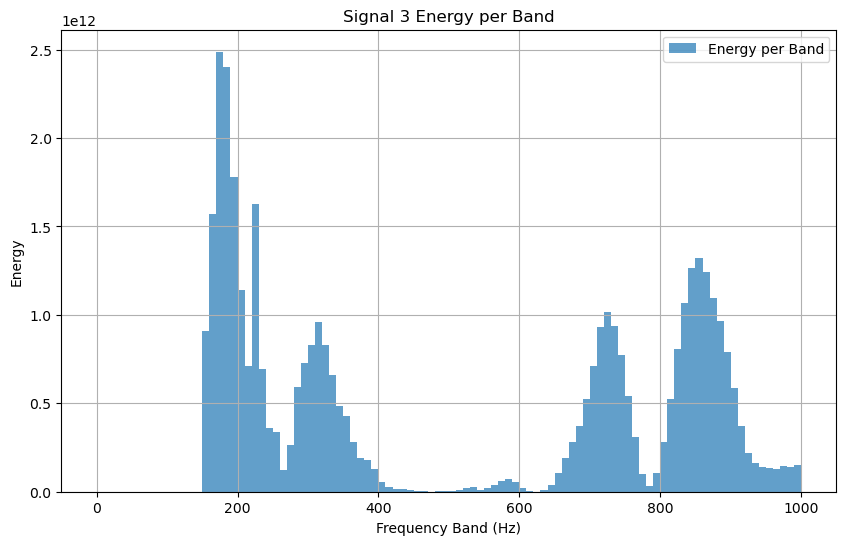

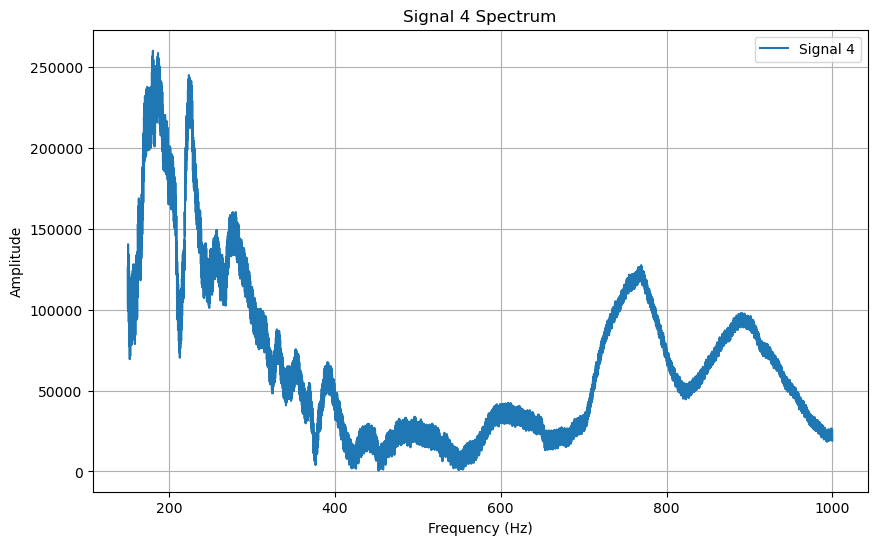

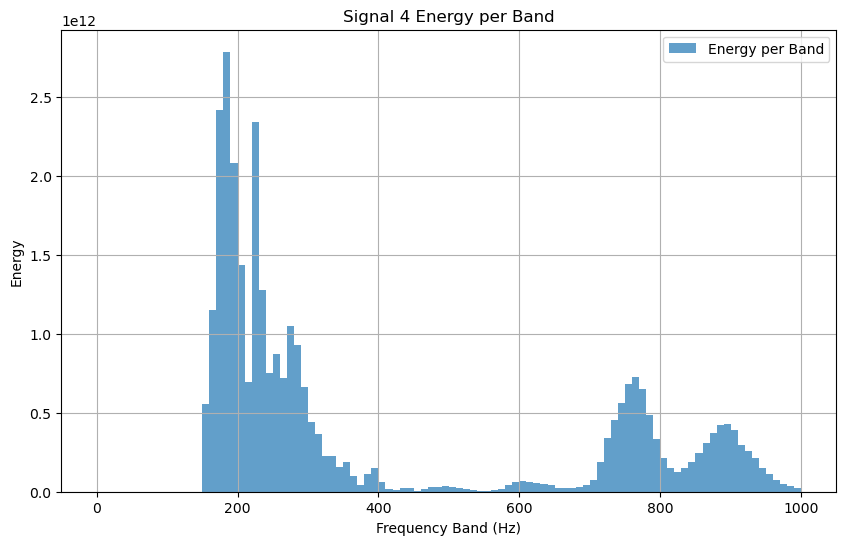

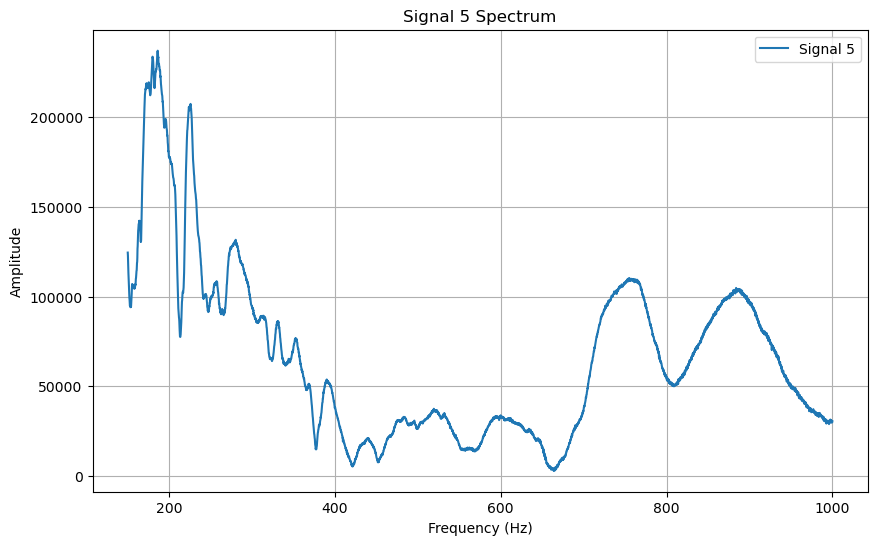

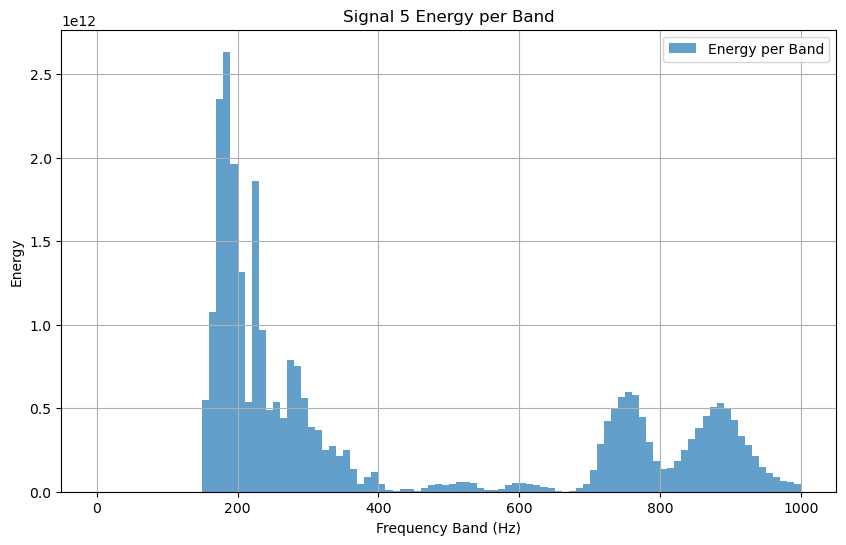

In [9]:
samplerateVect, testWavFileVect, files = readWavFolder("../../../Data/Sound/P1")
print(len(samplerateVect))
for idx in range(5):  # Loop through the first 5 elements
    spectrum, freqs = spectrumFromSignal(testWavFileVect[idx], samplerateVect[idx])
    b_e, b_f = energy_per_frequency_band_from_spectrum(spectrum, freqs, band_width=10)
    
    # Plot the spectrum
    plt.figure(figsize=(10, 6))
    plt.plot(freqs, spectrum, label=f"Signal {idx + 1}")
    plt.title(f"Signal {idx + 1} Spectrum")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot the energy per band
    plt.figure(figsize=(10, 6))
    plt.bar(b_f, b_e, width=10, alpha=0.7, label="Energy per Band", align='center')
    plt.title(f"Signal {idx + 1} Energy per Band")
    plt.xlabel("Frequency Band (Hz)")
    plt.ylabel("Energy")
    plt.legend()
    plt.grid()
    plt.show()

## Main

In [10]:
n_neighbors_range = range(1, 31, 3)
weights_options = ['uniform', 'distance']
metric_options = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']

results = []

for bw in range(10, 81, 10):
    print(f'bw {bw}')
    X_bandHz = []
    X_bandEnergy=[]
    Y_Label=[]

    samplerateVect,WavFileVect,filesName = readWavFolder("../../../Data/Sound/P1")
    spectrumVect=[]

    for i in range(len(WavFileVect)):
        spectrum, freqs = spectrumFromSignal(WavFileVect[i], samplerateVect[i])

        b_e, b_f = energy_per_frequency_band_from_spectrum(spectrum, freqs, band_width=bw)
        X_bandHz.append(b_f)
        X_bandEnergy.append(b_e)
        position=1
        if "C" in filesName[i]:
            position=1
        elif "S" in filesName[i]:
            position=2
        elif "V" in filesName[i]:
            position=3

        Y_Label.append(position)

    X_bandEnergy = [peak_val / np.max(peak_val) for peak_val in X_bandEnergy]

    max_length = max(max(len(p) for p in X_bandHz), max(len(a) for a in X_bandEnergy))
    X_peaksHz_padded = [np.pad(p, (0, max_length - len(p)), constant_values=0) for p in X_bandHz]
    X_peaksAmplitude_padded = [np.pad(a, (0, max_length - len(a)), constant_values=0) for a in X_bandEnergy]

    X = np.hstack((np.array(X_peaksHz_padded), np.array(X_peaksAmplitude_padded)))

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(Y_Label)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    for n_neighbors in n_neighbors_range:
        for weights in weights_options:
            for metric in metric_options:
                knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)
                knn.fit(X_train, y_train)

                y_pred = knn.predict(X_test)
                accuracy_test = accuracy_score(y_test, y_pred)

                y_train_pred = knn.predict(X_train)
                accuracy_train = accuracy_score(y_train, y_train_pred)
                
                results.append({
                    'bw': bw,
                    'n_neighbors': n_neighbors,
                    'weights': weights,
                    'metric': metric,
                    'accuracy_train': accuracy_train,
                    'accuracy_test': accuracy_test
                })

results_df = pd.DataFrame(results)

bw 10
bw 20
bw 30
bw 40
bw 50
bw 60
bw 70
bw 80


### Save the results

In [11]:

if os.path.exists("results_sknn_energy.xlsx"):
    os.remove("results_sknn_energy.xlsx")
results_df.to_excel("results_sknn_energy.xlsx", index=False)
print("Results have been saved to 'results_sknn_energy.xlsx'.")

Results have been saved to 'results_sknn_energy.xlsx'.


### Computing the best model

In [18]:
# Get the best configuration
best_config = results_df.loc[results_df['accuracy_test'].idxmax()]
best_n_neighbors = int(best_config['n_neighbors'])
best_weights = best_config['weights']
best_metric = best_config['metric']
best_bw = int(best_config['bw'])

print(f"Best Hyperparameters:")
print(f"  n_neighbors: {best_n_neighbors}")
print(f"  weights: {best_weights}")
print(f"  metric: {best_metric}")
print(f"  bw: {best_bw}")

# Extract features again for the best n_peak
X_bandHz = []
X_bandEnergy = []
Y_Label = []

for i in range(len(WavFileVect)):
    spectrum, freqs = spectrumFromSignal(WavFileVect[i], samplerateVect[i])
    b_e, b_f = energy_per_frequency_band_from_spectrum(spectrum, freqs, band_width=bw)
    X_bandHz.append(b_f)
    X_bandEnergy.append(b_e)
    position=1
    if "C" in filesName[i]:
        position=1
    elif "S" in filesName[i]:
        position=2
    elif "V" in filesName[i]:
        position=3
    Y_Label.append(position)
    X_bandEnergy = [peak_val / np.max(peak_val) for peak_val in X_bandEnergy]
    max_length = max(max(len(p) for p in X_bandHz), max(len(a) for a in X_bandEnergy))
    X_peaksHz_padded = [np.pad(p, (0, max_length - len(p)), constant_values=0) for p in X_bandHz]
    X_peaksAmplitude_padded = [np.pad(a, (0, max_length - len(a)), constant_values=0) for a in X_bandEnergy]
    X = np.hstack((np.array(X_peaksHz_padded), np.array(X_peaksAmplitude_padded)))
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(Y_Label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the KNN model with the best configuration
knn_best = KNeighborsClassifier(n_neighbors=best_n_neighbors, weights=best_weights, metric=best_metric)
knn_best.fit(X_train, y_train)

# Predict and visualize
y_pred_best = knn_best.predict(X_test)


Best Hyperparameters:
  n_neighbors: 4
  weights: distance
  metric: manhattan
  bw: 20


### Visualisation

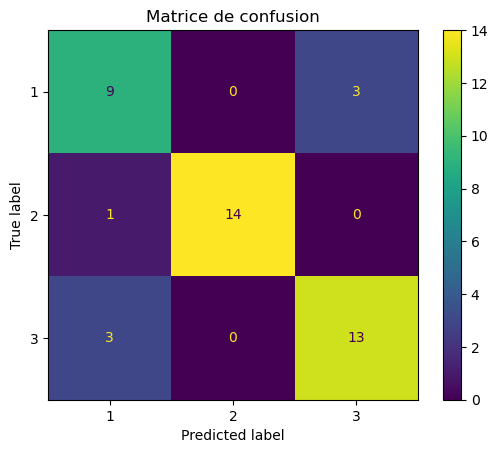

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best, display_labels=label_encoder.classes_)
plt.title("Matrice de confusion")
plt.show()